In [1]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/data/MyDrive/final_project/lg_data_fix.csv')

In [3]:
# import os
# os.environ['CUDA_LAUNCG_BLOCKING'] = '1'
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['CUDA_LAUNCG_BLOCKING']

In [4]:
df.head()

,Unnamed: 0,date,links,titles,contests,present_closing price,대비,판별
0,1543,2022-07-06,https://finance.naver.com/item/news_read.naver...,"""LG엔솔 목표가 8.77% 하향…락업 해제만 지나면 주가 오를 것""-...",목표가 52만원 제시한국투자증권은 6일 LG에너지솔루션에 대해 2025년 상각전 영...,370500.0,3000.0,1.0
1,1535,2022-07-06,https://finance.naver.com/item/news_read.naver...,LG엔솔 “日 이스즈자동차과 배터리 공급 협의중”,[이데일리 정두리 기자] LG에너지솔루션(373220)은 일본 이스즈자동차에 1조원...,370500.0,3000.0,1.0
2,1536,2022-07-06,https://finance.naver.com/item/news_read.naver...,"[한경 라씨로] 하락장 속 나홀로 상승한 LG엔솔, 기관이 쓸어 담아","한경라씨로는 인공지능(AI) 알고리즘을 기반으로 상장 종목들의 시세, 수급, 시황 ...",370500.0,3000.0,1.0
3,1537,2022-07-06,https://finance.naver.com/item/news_read.naver...,"[특징주] LG엔솔, '1조 규모’ 배터리 공급 소식에 강세",[헤럴드경제=양대근 기자] LG에너지솔루션이 일본 상용차업체에 1조원 규모 배터리를...,370500.0,3000.0,1.0
4,1542,2022-07-06,https://finance.naver.com/item/news_read.naver...,"“LG엔솔, 3분기부터 업황 개선…2차전지 내 최선호주”",[한국투자증권 보고서]목표주가 57만→52만 하향[서울경제] 한국투자증권이 LG에너...,370500.0,3000.0,1.0


In [5]:
df = df[df['판별'].notnull()]  # 판별이 null인 row 제외

In [6]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git # 다운로드
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh # 소스를 실행

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 9.72 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 10.1 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-07-09 11:46:29--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 30

In [9]:
# train, test split
from sklearn.model_selection import train_test_split
X = df['contests']
y = df['판별']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1235,), (309,), (1235,), (309,))

In [10]:
from torchtext.vocab import build_vocab_from_iterator
from tqdm.auto import tqdm
from konlpy.tag import Okt
okt = Okt()
def tokenizer(text):
    tokens = okt.pos(text) # 토큰화
    return [token[0] for token in tokens if token[1][0] in "NVJA"]

def yield_tokens(data,tokenizer):
    for text in tqdm(data):
        yield tokenizer(text)

gen = yield_tokens(X_train,tokenizer)

vocab = build_vocab_from_iterator(gen, specials=["<pad>","<unk>", "<sos>", "<eos>"])

vocab.set_default_index(vocab["<unk>"])

print(len(vocab))
# vocab에 저장된 토큰 개수는 20025개

features_train = [] # 문장을 토큰화한뒤 숫자로 변경 후 저장할 리스트

for row in tqdm(X_train):
    tokens = tokenizer(row)
    features_train.append(vocab(tokens))

features_test = [] # test 기사를 토큰화한뒤 숫자로 변경 후 저장할 리스트

for row in tqdm(X_test):
    tokens = tokenizer(row)
    features_test.append(vocab(tokens))

  0%|          | 0/1235 [00:00<?, ?it/s]

20653


  0%|          | 0/1235 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

In [11]:
# padding
# 1. max_len확인 - 1541개
max_len = max(len(lst) for lst in features_train)
max_len_test = max(len(lst) for lst in features_test)
max_len, max_len_test
# ver1: padding은 2041기준으로 해준다.
# ver2: padding은 4000으로 해준다

(2041, 1313)

In [12]:
# 패딩 적용 - train
print(vocab(['<pad>']))
feature_lst = []
for row in tqdm(features_train):
    # max len과 길이가 같아질때까지 더함
    # <start of sentence> 및 <end of sentence>도 앞뒤로 추가해준다 [2], [3]
    feature_lst.append([2] + row + [0]*(max_len - len(row)) + [3])

# 패딩 적용 - test
# 문장 시작과 끝을 알리는 패딩 동일하게 붙임
feature_lst_test = []
for row in tqdm(features_test):
    # max len과 길이가 같아질때까지 더함
    feature_lst_test.append([2] + row + [0]*(max_len - len(row)) + [3])

[0]


  0%|          | 0/1235 [00:00<?, ?it/s]

  0%|          | 0/309 [00:00<?, ?it/s]

In [13]:
np.array(feature_lst).shape, np.array(feature_lst_test).shape

((1235, 2043), (309, 2043))

In [14]:
feature_train= np.array(feature_lst)
feature_test = np.array(feature_lst_test)
target_train = np.array(y_train)
target_test = np.array(y_test)
target_BCE_train = np.array(y_train).reshape(-1, 1)
target_BCE_test = np.array(y_test).reshape(-1, 1)

feature_train.shape, feature_test.shape, target_train.shape, target_test.shape, target_BCE_train.shape, target_BCE_test.shape

((1235, 2043), (309, 2043), (1235,), (309,), (1235, 1), (309, 1))

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

class StockNewsDataset(Dataset):

    def __init__(self, feature, target=None):
        self.feature = torch.LongTensor(feature)
        self.target = torch.LongTensor(target)

    def __len__(self):
        return self.feature.shape[0]

    def __getitem__(self, idx:int):
        return self.feature[idx], self.target[idx]

In [16]:
dataset_train = StockNewsDataset(feature_train, target_train)
dataset_test = StockNewsDataset(feature_test, target_test)

dataloader_train = DataLoader(dataset_train, batch_size=100, shuffle=True, drop_last=True)
dataloader_test = DataLoader(dataset_test, batch_size=309, shuffle=False, drop_last=False)

In [46]:
# next(iter(dataloader_train))

## Model 설계 - Cross Entropy Loss

In [17]:
class LSTMModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, device='cuda', num_output=2, dim_embed=64, hidden_size=64, linear_size=64, num_layers=2):
        super().__init__()
        self.device = device
        self.num_output = num_output
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.emb_layer = torch.nn.Embedding(vocab_size,embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=0.3, bidirectional=True)
        self.fclayer = nn.Linear(hidden_size, linear_size)
        self.outlayer = nn.Linear(linear_size, num_output)


    def forward(self, x): # (batch, seq_len)
        scaler = 2 if self.lstm.bidirectional == True else 1 # Bi-LSTM(2), LSTM(1)

        emb = self.emb_layer(x) # (batch, seq_len, dim_embed)

        # 초기화
        hidden_state = torch.zeros(self.num_layers*scaler, emb.size(0),
                                    self.hidden_size, requires_grad=True).to(self.device)
        cell_state = torch.zeros(self.num_layers*scaler, emb.size(0),
                                    self.hidden_size, requires_grad=True).to(self.device)

        out, (hidden_state, cell_state) = self.lstm(emb.transpose(1,0), (hidden_state, cell_state))
        h = hidden_state[-1] # 마지막 hidden 값만 사용

        h = self.fclayer(h).relu()
        predict = self.outlayer(h)

        return predict

In [18]:
class LSTMModel2(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, device='cuda', num_output=2, dim_embed=64, hidden_size=64, num_layers=2):
        super().__init__()
        self.device = device
        self.num_output = num_output
        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.emb_layer = torch.nn.Embedding(vocab_size,embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                            num_layers=num_layers, dropout=0.3, bidirectional=True)
        self.fclayer = nn.Linear(hidden_size, num_output)



    def forward(self, x): # (batch, seq_len)
        scaler = 2 if self.lstm.bidirectional == True else 1 # Bi-LSTM(2), LSTM(1)

        emb = self.emb_layer(x) # (batch, seq_len, dim_embed)

        # 초기화
        hidden_state = torch.zeros(self.num_layers*scaler, emb.size(0),
                                    self.hidden_size, requires_grad=True).to(self.device)
        cell_state = torch.zeros(self.num_layers*scaler, emb.size(0),
                                    self.hidden_size, requires_grad=True).to(self.device)

        out, (hidden_state, cell_state) = self.lstm(emb.transpose(1,0), (hidden_state, cell_state))
        h = hidden_state[-1] # 마지막 hidden 값만 사용

        predict = self.fclayer(h)

        return predict

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [20]:
model1 = LSTMModel(len(vocab)).to(device)
model2 = LSTMModel2(len(vocab)).to(device)
model1, model2

(LSTMModel(
   (emb_layer): Embedding(20653, 128)
   (lstm): LSTM(128, 64, num_layers=2, dropout=0.3, bidirectional=True)
   (fclayer): Linear(in_features=64, out_features=64, bias=True)
   (outlayer): Linear(in_features=64, out_features=2, bias=True)
 ),
 LSTMModel2(
   (emb_layer): Embedding(20653, 128)
   (lstm): LSTM(128, 64, num_layers=2, dropout=0.3, bidirectional=True)
   (fclayer): Linear(in_features=64, out_features=2, bias=True)
 ))

In [23]:
N_EPOCH = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

acc_list = []
train_loss_list = []
test_loss_list = []
patience = 0
loss_init = torch.inf

for epoch in range(N_EPOCH):
    train_loss = 0
    val_acc = 0
    val_loss = 0
    model1.train()

    for X_train, y_train in dataloader_train:
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred = model1(X_train)
        loss = loss_fn(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(dataloader_train)

    with torch.no_grad():
        for X_val, y_val in dataloader_test:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred_val = model1(X_val)
            pred_val = nn.Sigmoid()(pred_val)

            val_loss = loss_fn(pred_val, y_val)

            pred_label = pred_val.argmax(axis = -1)

            val_acc += torch.sum(pred_label == y_val).item()

        val_loss /=len(dataloader_test)
        val_acc /= len(dataloader_test.dataset)

    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1}, train_loss= {train_loss}, test_loss = {val_loss}, test_accuracy = {val_acc}")
    acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(val_loss)

    # if loss_init > test_loss:
    #     pa


epoch:10, train_loss= 0.13743394271781048, test_loss = 0.6220037341117859, test_accuracy = 0.656957928802589
epoch:20, train_loss= 0.021733651597363252, test_loss = 0.6181952953338623, test_accuracy = 0.6763754045307443
epoch:30, train_loss= 0.006664195949269924, test_loss = 0.6305267214775085, test_accuracy = 0.6634304207119741
epoch:40, train_loss= 0.005540135998065428, test_loss = 0.6252540946006775, test_accuracy = 0.6796116504854369
epoch:50, train_loss= 0.017849825768886756, test_loss = 0.616243302822113, test_accuracy = 0.6796116504854369
epoch:60, train_loss= 0.004092230651925395, test_loss = 0.619705080986023, test_accuracy = 0.6796116504854369
epoch:70, train_loss= 0.0032179890807431852, test_loss = 0.617270827293396, test_accuracy = 0.6925566343042071
epoch:80, train_loss= 0.0030106351838791547, test_loss = 0.6218239068984985, test_accuracy = 0.6763754045307443
epoch:90, train_loss= 0.003111775013318644, test_loss = 0.6273150444030762, test_accuracy = 0.6763754045307443
epoc

In [24]:
N_EPOCH = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

acc_list = []
train_loss_list = []
test_loss_list = []
patience = 0
loss_init = torch.inf

for epoch in range(N_EPOCH):
    train_loss = 0
    val_acc = 0
    val_loss = 0
    model2.train()

    for X_train, y_train in dataloader_train:
        X_train, y_train = X_train.to(device), y_train.to(device)
        pred = model2(X_train)
        loss = loss_fn(pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(dataloader_train)

    with torch.no_grad():
        for X_val, y_val in dataloader_test:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred_val = model2(X_val)
            pred_val = nn.Sigmoid()(pred_val)

            val_loss = loss_fn(pred_val, y_val)

            pred_label = pred_val.argmax(axis = -1)

            val_acc += torch.sum(pred_label == y_val).item()

        val_loss /=len(dataloader_test)
        val_acc /= len(dataloader_test.dataset)

    if (epoch+1) % 10 == 0:
        print(f"epoch:{epoch+1}, train_loss= {train_loss}, test_loss = {val_loss}, test_accuracy = {val_acc}")
    acc_list.append(val_acc)
    train_loss_list.append(train_loss)
    test_loss_list.append(val_loss)

    # if loss_init > test_loss:
    #     pa


epoch:10, train_loss= 0.14937923103570938, test_loss = 0.5798515677452087, test_accuracy = 0.7184466019417476
epoch:20, train_loss= 0.037802347098477185, test_loss = 0.5724667310714722, test_accuracy = 0.7184466019417476
epoch:30, train_loss= 0.013603284993829826, test_loss = 0.5739946365356445, test_accuracy = 0.7216828478964401
epoch:40, train_loss= 0.0029462434807404256, test_loss = 0.5782594084739685, test_accuracy = 0.7249190938511327
epoch:50, train_loss= 0.0034428948407973317, test_loss = 0.5778239369392395, test_accuracy = 0.7249190938511327
epoch:60, train_loss= 0.0032283888419139353, test_loss = 0.5740898251533508, test_accuracy = 0.7281553398058253
epoch:70, train_loss= 0.003325388295100614, test_loss = 0.5761207938194275, test_accuracy = 0.7313915857605178
epoch:80, train_loss= 0.002665974277382096, test_loss = 0.5806426405906677, test_accuracy = 0.7184466019417476
epoch:90, train_loss= 0.003246894380329953, test_loss = 0.573317289352417, test_accuracy = 0.7313915857605178


In [46]:
from sklearn.metrics import f1_score

X, y = next(iter(dataloader_test))
with torch.no_grad():
    pred = model2(X.to(device))
    pred_label = pred.argmax(axis = -1)

y, pred_label = np.array(y.to('cpu')), np.array(pred_label.to('cpu'))
y

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [47]:
pred_label

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,

In [48]:
f1_score(pred_label, y)

0.7797468354430379

In [55]:
pred_soft = pred.softmax(dim=1)
pred_soft.shape

torch.Size([309, 2])

In [56]:
pred_max = pred_soft.argmax(dim=1)

In [57]:
pred_max

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,

In [59]:
pred_max

tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,

In [51]:
with torch.no_grad():
    pred = model2(X.to(device))
nn.Softmax(dim=-1)(pred)

tensor([[3.2002e-05, 9.9997e-01],
        [1.9461e-05, 9.9998e-01],
        [3.1819e-04, 9.9968e-01],
        [9.9926e-01, 7.4335e-04],
        [1.7946e-05, 9.9998e-01],
        [3.4357e-05, 9.9997e-01],
        [9.4971e-01, 5.0291e-02],
        [1.8318e-05, 9.9998e-01],
        [1.4173e-04, 9.9986e-01],
        [1.5865e-02, 9.8413e-01],
        [9.9971e-01, 2.8563e-04],
        [2.7004e-05, 9.9997e-01],
        [3.7975e-05, 9.9996e-01],
        [9.9983e-01, 1.7246e-04],
        [3.8608e-03, 9.9614e-01],
        [7.7849e-05, 9.9992e-01],
        [9.9991e-01, 8.8806e-05],
        [2.6149e-05, 9.9997e-01],
        [9.9998e-01, 2.0737e-05],
        [9.9995e-01, 5.0389e-05],
        [3.4605e-05, 9.9997e-01],
        [9.9992e-01, 8.2919e-05],
        [9.9468e-01, 5.3222e-03],
        [9.8661e-01, 1.3390e-02],
        [4.4950e-05, 9.9996e-01],
        [1.7879e-05, 9.9998e-01],
        [9.7013e-05, 9.9990e-01],
        [9.9988e-01, 1.2345e-04],
        [2.2449e-05, 9.9998e-01],
        [3.860

Text(0.5, 1.0, 'test_loss')

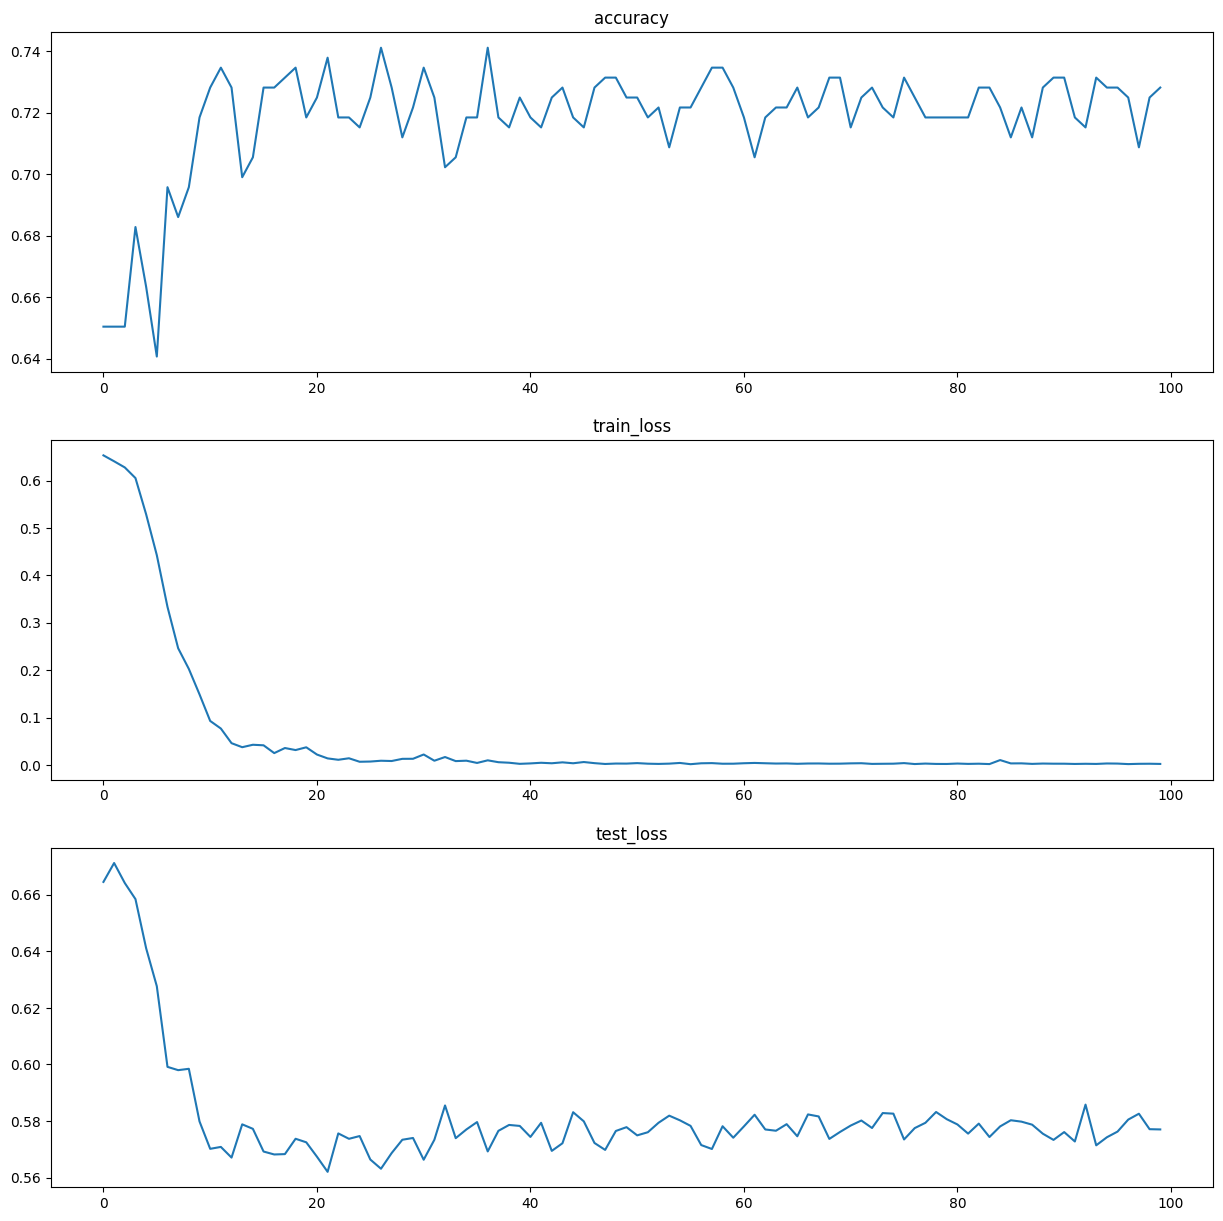

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
plt.subplot(3, 1, 1)
plt.plot(acc_list)
plt.title('accuracy')

plt.subplot(3, 1, 2)
plt.plot(train_loss_list)
plt.title('train_loss')

plt.subplot(3, 1, 3)
plt.plot(torch.tensor(test_loss_list).to('cpu'))
plt.title('test_loss')

In [36]:
# N_EPOCH = 100
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# acc_list = []
# train_loss_list = []
# test_loss_list = []
# patience = 0
# loss_init = torch.inf

# for epoch in range(N_EPOCH):
#     train_loss = 0
#     val_acc = 0
#     val_loss = 0
#     model.train()

#     for X_train, y_train in dataloader_train:
#         X_train, y_train = X_train.to(device), y_train.to(device)
#         pred = model1(X_train)
#         loss = loss_fn(pred, y_train)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     train_loss /= len(dataloader_train)

#     with torch.no_grad():
#         for X_val, y_val in dataloader_test:
#             X_val, y_val = X_val.to(device), y_val.to(device)
#             pred_val = model(X_val)
#             pred_val = nn.Sigmoid()(pred_val)

#             val_loss = loss_fn(pred_val, y_val)

#             pred_label = pred_val.argmax(axis = -1)

#             val_acc += torch.sum(pred_label == y_val).item()

#         val_loss /=len(dataloader_test)
#         val_acc /= len(dataloader_test.dataset)

#     if (epoch+1) % 10 == 0:
#         print(f"epoch:{epoch+1}, train_loss= {train_loss}, test_loss = {val_loss}, test_accuracy = {val_acc}")
#     acc_list.append(val_acc)
#     train_loss_list.append(train_loss)
#     test_loss_list.append(val_loss)

#     # if loss_init > test_loss:
#     #     pa


OutOfMemoryError: ignored

Text(0.5, 1.0, 'test_loss')

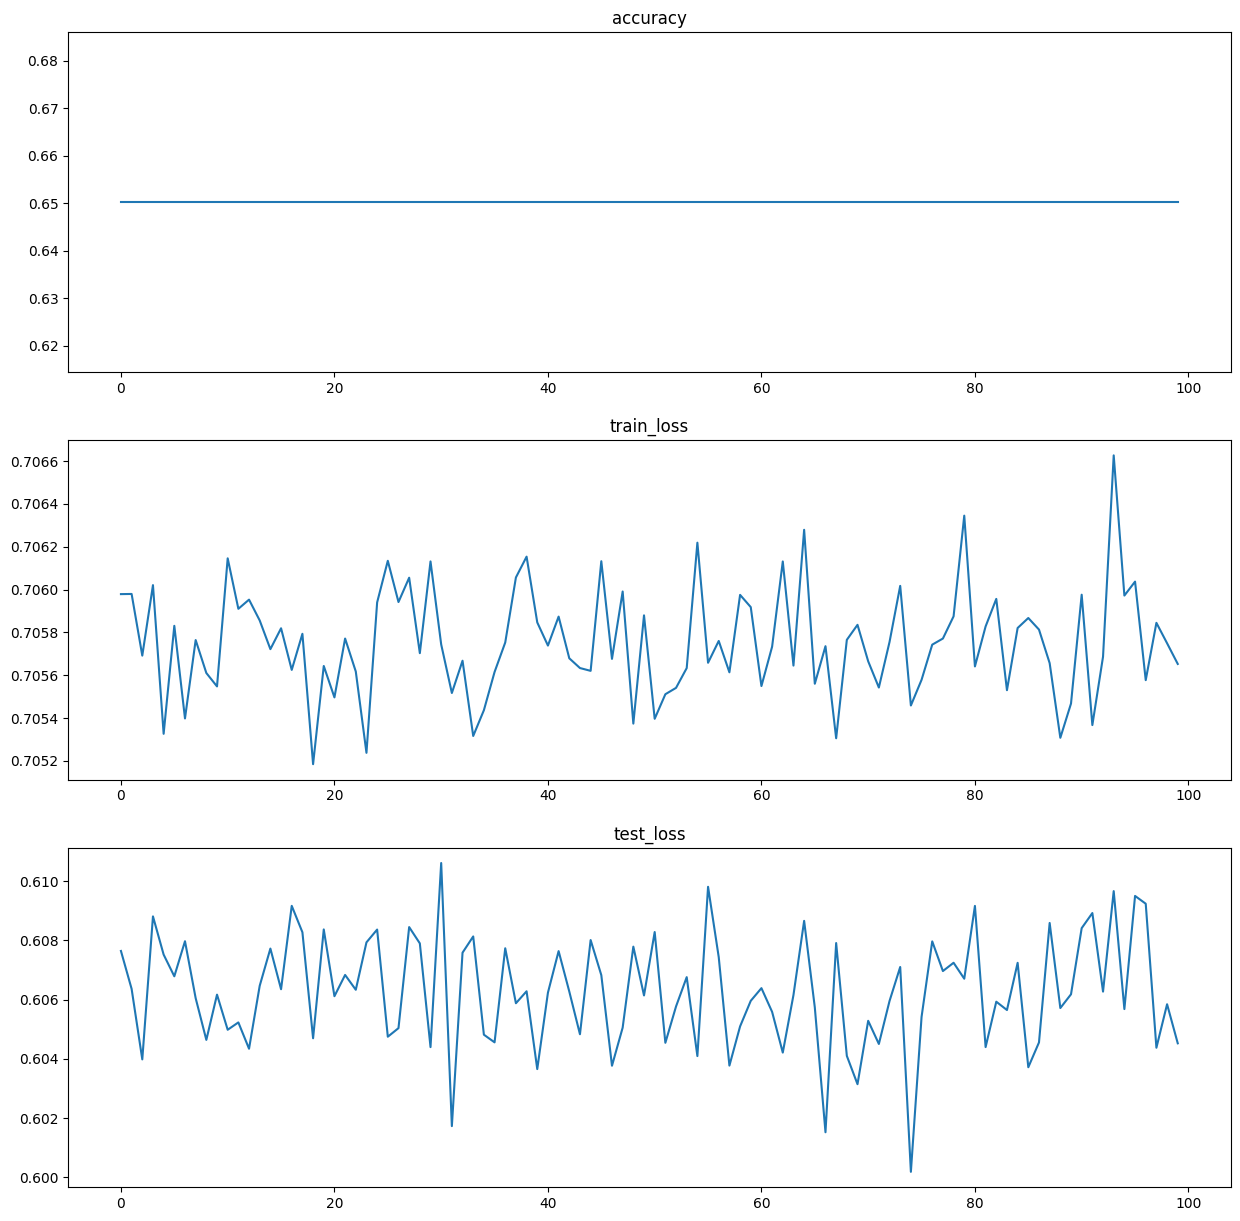

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 15))
# plt.subplot(3, 1, 1)
# plt.plot(acc_list)
# plt.title('accuracy')

# plt.subplot(3, 1, 2)
# plt.plot(train_loss_list)
# plt.title('train_loss')

# plt.subplot(3, 1, 3)
# plt.plot(torch.tensor(test_loss_list).to('cpu'))
# plt.title('test_loss')

In [ ]:
# model1(next(iter(dataloader_test))[0].to(device))

tensor([[0.4701],
        [0.4759],
        [0.4806],
        [0.4735],
        [0.4825],
        [0.4831],
        [0.4845],
        [0.4776],
        [0.4740],
        [0.4712],
        [0.4803],
        [0.4794],
        [0.4789],
        [0.4801],
        [0.4839],
        [0.4871],
        [0.4838],
        [0.4783],
        [0.4788],
        [0.4798],
        [0.4827],
        [0.4815],
        [0.4812],
        [0.4869],
        [0.4804],
        [0.4787],
        [0.4710],
        [0.4814],
        [0.4886],
        [0.4803],
        [0.4816],
        [0.4741],
        [0.4743],
        [0.4738],
        [0.4839],
        [0.4863],
        [0.4782],
        [0.4776],
        [0.4804],
        [0.4706],
        [0.4878],
        [0.4804],
        [0.4811],
        [0.4785],
        [0.4826],
        [0.4799],
        [0.4825],
        [0.4794],
        [0.4898],
        [0.4814],
        [0.4768],
        [0.4806],
        [0.4840],
        [0.4802],
        [0.4871],
        [0

In [35]:
# class LSTMModelBCE(nn.Module):
#     def __init__(self, vocab_size, embedding_dim=128, device='cuda', num_output=1, dim_embed=64, hidden_size=64, num_layers=2):
#         super().__init__()
#         self.device = device
#         self.num_output = num_output
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers


#         self.emb_layer = nn.Embedding(vocab_size,embedding_dim)

#         self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
#                             num_layers=num_layers, dropout=0.3, bidirectional=True)
#         self.fclayer = nn.Linear(hidden_size, num_output)


#     def forward(self, x): # (batch, seq_len)
#         scaler = 2 if self.lstm.bidirectional == True else 1 # Bi-LSTM(2), LSTM(1)

#         emb = self.emb_layer(x) # (batch, seq_len, dim_embed)

#         # 초기화
#         hidden_state = torch.zeros(self.num_layers*scaler, emb.size(0),
#                                     self.hidden_size, requires_grad=True).to(self.device)
#         cell_state = torch.zeros(self.num_layers*scaler, emb.size(0),
#                                     self.hidden_size, requires_grad=True).to(self.device)

#         out, (hidden_state, cell_state) = self.lstm(emb.transpose(1,0), (hidden_state, cell_state))
#         h = hidden_state[-1] # 마지막 hidden 값만 사용

#         predict = self.fclayer(h)
#         predict = nn.Sigmoid()(predict)

#         return predict

In [ ]:
# N_EPOCH = 100
# loss_fn = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# acc_list = []
# train_loss_list = []
# test_loss_list = []
# patience = 0
# loss_init = torch.inf

# for epoch in range(N_EPOCH):
#     train_loss = 0
#     val_acc = 0
#     val_loss = 0
#     model.train()

#     for X_train, y_train in dataloader_train:
#         X_train, y_train = X_train.to(device), y_train.to(device)
#         pred = model1(X_train)
#         loss = loss_fn(pred, y_train)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item()

#     train_loss /= len(dataloader_train)

#     with torch.no_grad():
#         for X_val, y_val in dataloader_test:
#             X_val, y_val = X_val.to(device), y_val.to(device)
#             pred_val = model(X_val)
#             pred_val = nn.Sigmoid()(pred_val)

#             val_loss = loss_fn(pred_val, y_val)

#             pred_label = (pred_val > 0.5).to(torch.float32)

#             val_acc += torch.sum(pred_label == y_val).item()

#         val_loss /=len(dataloader_test)
#         val_acc /= len(dataloader_test.dataset)

#     if (epoch+1) % 10 == 0:
#         print(f"epoch:{epoch+1}, train_loss= {train_loss}, test_loss = {val_loss}, test_accuracy = {val_acc}")
#     acc_list.append(val_acc)
#     train_loss_list.append(train_loss)
#     test_loss_list.append(val_loss)

#     # if loss_init > test_loss:
#     #     pa
